In [1]:
#### Libraries and packages
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

zsh:1: command not found: nvcc
torch:  1.12 ; cuda:  1.12.1
detectron2: 0.6


In [3]:
# install tesseract OCR for key-value extraction
#!sudo apt install tesseract-ocr 
!pip install pytesseract

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

/Users/pritiranjansahoo/miniforge3/envs/legion3.0/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/pritiranjansahoo/miniforge3/envs/legion3.0/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <D9493EF5-8DAB-3A5D-85D5-684F04544B84> /Users/pritiranjansahoo/miniforge3/envs/legion3.0/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <BB02660F-1D5B-3388-B48B-486877D726F6> /Users/pritiranjansahoo/miniforge3/envs/legion3.0/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [5]:
# As our dataset is already in COCO format, register coco format dataset as below:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("invoices_train1", {},
                        "../documentations and prior code/Team Project/files/resized_jsons/train_json/train.json",
                        "../documentations and prior code/Team Project/files/resized_jsons/train/")
register_coco_instances("invoices_val1", {},
                        "../documentations and prior code/Team Project/files/resized_jsons/test_json/val.json",
                        "../documentations and prior code/Team Project/files/resized_jsons/test/")

In [7]:
# Configuration of Detectron2.0
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("invoices_train1",)
cfg.DATASETS.TEST = ("invoices_val1",)
cfg.DATALOADER.NUM_WORKERS = 4
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 # No. of classes = [Name, Address, Date, Total]
cfg.TEST.EVAL_PERIOD = 500
cfg.OUTPUT_DIR = "../documentations and prior code/Team Project/files/resized_jsons/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

NameError: name 'CocoTrainer' is not defined

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
cfg.DATASETS.TEST = ("invoices_val1", )
predictor = DefaultPredictor(cfg)

WARNING [12/06 00:55:59 d2.checkpoint.c2_model_loading]: Shape of roi_heads.box_predictor.bbox_pred.bias in checkpoint is torch.Size([16]), while shape of roi_heads.box_predictor.bbox_pred.bias in model is torch.Size([320]).
WARNING [12/06 00:55:59 d2.checkpoint.c2_model_loading]: roi_heads.box_predictor.bbox_pred.bias will not be loaded. Please double check and see if this is desired.
WARNING [12/06 00:55:59 d2.checkpoint.c2_model_loading]: Shape of roi_heads.box_predictor.bbox_pred.weight in checkpoint is torch.Size([16, 1024]), while shape of roi_heads.box_predictor.bbox_pred.weight in model is torch.Size([320, 1024]).
WARNING [12/06 00:55:59 d2.checkpoint.c2_model_loading]: roi_heads.box_predictor.bbox_pred.weight will not be loaded. Please double check and see if this is desired.
WARNING [12/06 00:55:59 d2.checkpoint.c2_model_loading]: Shape of roi_heads.box_predictor.cls_score.bias in checkpoint is torch.Size([5]), while shape of roi_heads.box_predictor.cls_score.bias in model is

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


WARNING [12/06 00:56:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/06 00:56:23 d2.data.datasets.coco]: Loaded 18 images in COCO format from /content/drive/MyDrive/project_invoice_dataset_coco/resized_train/val.json


/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


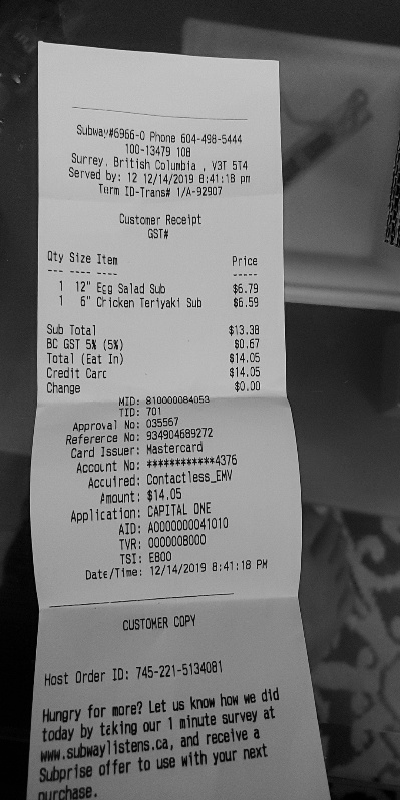

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


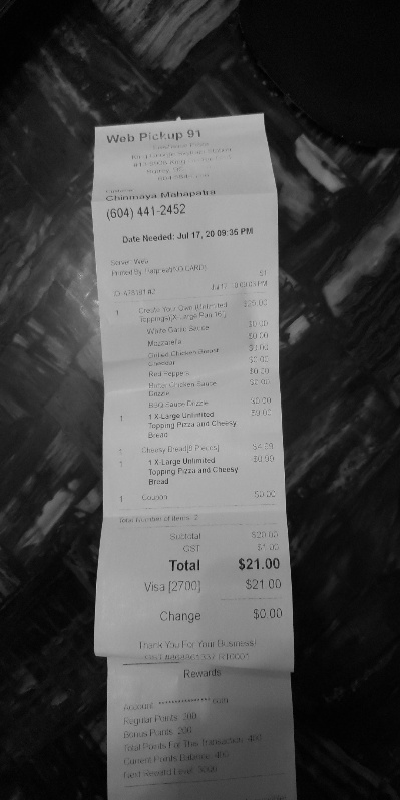

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


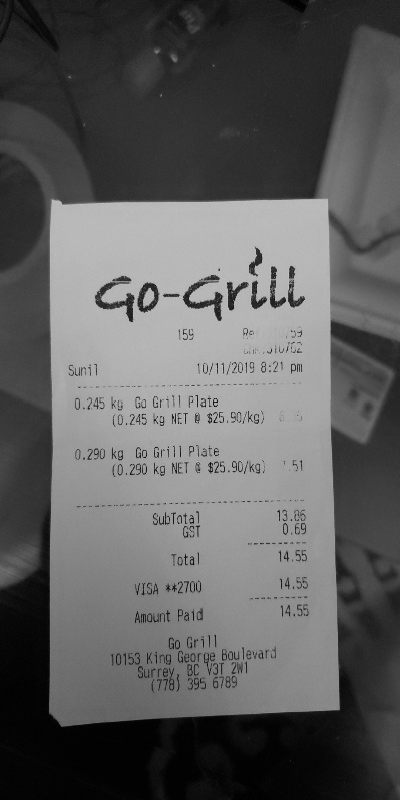

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


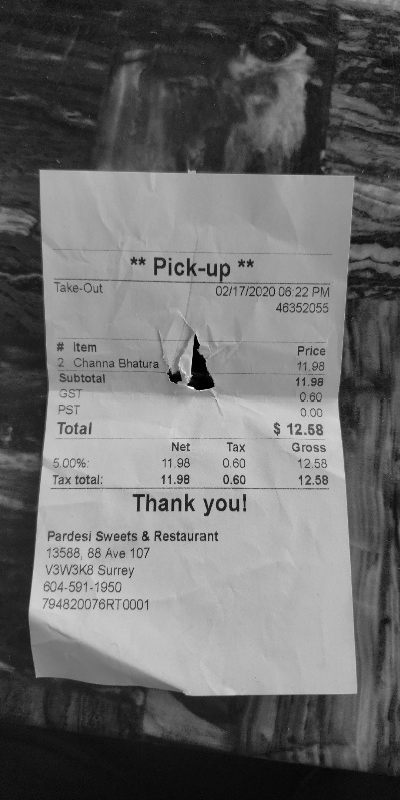

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


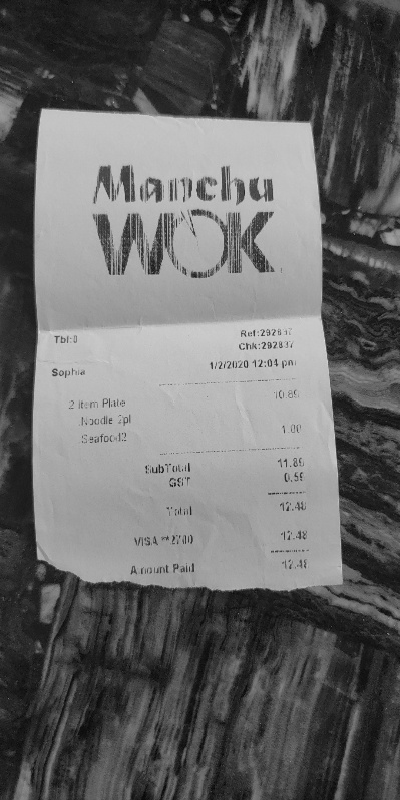

In [ ]:
test_metadata = MetadataCatalog.get("invoices_val1")
test_dataset_dicts = DatasetCatalog.get("invoices_val1")

from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 5):    
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                   scale=1.0, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
  print(outputs["instances"].pred_classes)
  print(outputs["instances"].pred_boxes)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("invoices_val1", cfg, False, output_dir="/content/drive/MyDrive/output/")
val_loader = build_detection_test_loader(cfg, "invoices_val1")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

[11/09 18:08:28 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/09 18:08:28 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [11/09 18:08:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/09 18:08:28 d2.data.datasets.coco]: Loaded 18 images in COCO format from /content/drive/MyDrive/project_invoice_dataset_coco/resized_train/val.json
[11/09 18:08:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/09 18:08:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[11/09 18:08:28 d2.data.common]: Serializing 18 elements to byte tensors and concatenating them all ...
[11/09 18:08:28 d2.data.com

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[11/09 18:08:30 d2.evaluation.evaluator]: Inference done 11/18. Dataloading: 0.0012 s/iter. Inference: 0.1052 s/iter. Eval: 0.0002 s/iter. Total: 0.1066 s/iter. ETA=0:00:00
[11/09 18:08:31 d2.evaluation.evaluator]: Total inference time: 0:00:01.508441 (0.116034 s / iter per device, on 1 devices)
[11/09 18:08:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.104273 s / iter per device, on 1 devices)
[11/09 18:08:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/09 18:08:31 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/output/coco_instances_results.json
[11/09 18:08:32 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   al

OrderedDict([('bbox',
              {'AP': 44.68097963642519,
               'AP50': 68.7113663289406,
               'AP75': 51.553905390539065,
               'APs': 30.437057991513434,
               'APm': 50.0943748220976,
               'APl': 54.75247524752476,
               'AP-Name': 51.40784463061691,
               'AP-Address': 55.434543454345445,
               'AP-Total': 38.56634894258657,
               'AP-Date': 33.31518151815182})])

In [ ]:
im = cv2.imread("/content/drive/MyDrive/project_invoice_dataset_coco/test/111.jpg")
cv2_imshow(im)
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

AttributeError: ignored

In [ ]:
outputs

{'instances': Instances(num_instances=0, image_height=1920, image_width=1080, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}

Address
<class 'numpy.ndarray'>


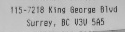

115-7218 King George Blvd
‘Surrey, 80 30 505

Name
<class 'numpy.ndarray'>


‘Shawarwa Palace

Total
<class 'numpy.ndarray'>


13.32

Total
<class 'numpy.ndarray'>


$13.32

Address
<class 'numpy.ndarray'>


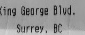

ing George Blvd.
are:

                    Name                                            Address  \
0  [‘Shawarwa Palace\n]  [115-7218 King George Blvd\n‘Surrey, 80 30 505...   

                   Total Date  
0  [13.32\n, $13.32\n]   []  


In [ ]:
# crop image and pass it to tesseract using bbox information
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pytesseract
df = pd.DataFrame(columns=['Name', 'Address', 'Total', 'Date'])
for d in random.sample(test_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    pred_classes = outputs["instances"].pred_classes.tolist()
    pred_bboxes = outputs["instances"].pred_boxes.tensor.tolist()
    class_dict = {0: 'Name', 1: 'Address', 2: 'Total', 3: 'Date' }
    name_list = []
    address_list = []
    date_list = []
    total_list = []
    for bbox in range(len(pred_bboxes)):
      tup = (class_dict[pred_classes[bbox]], pred_bboxes[bbox])
      print(tup[0])
      x = int(tup[1][0])
      y = int(tup[1][1])
      w = int(tup[1][2])
      h = int(tup[1][3])
    # x = int(outputs["instances"].pred_boxes[0].tensor.tolist()[0][0])
    # y = int(outputs["instances"].pred_boxes[0].tensor.tolist()[0][1])
    # w = int(outputs["instances"].pred_boxes[0].tensor.tolist()[0][2])
    # h = int(outputs["instances"].pred_boxes[0].tensor.tolist()[0][3])
      crop_img = im[y:h, x:w]
      cv2.imwrite("/content/drive/MyDrive/output/" + "cropped_" + str(bbox) + ".jpg", crop_img)
      print(type(crop_img))
      cv2_imshow(crop_img)
      pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')
      cropped_img = cv2.imread("/content/drive/MyDrive/output/" + "cropped_" + str(bbox) + ".jpg")
      text = pytesseract.image_to_string(cropped_img, lang='eng', config='-psm 1')
      print(text)
      if (tup[0]) == 'Name':
        name_list.append(text)
      elif (tup[0]) == 'Address':
        address_list.append(text)
      elif (tup[0]) == 'Total':
        total_list.append(text)
      elif (tup[0]) == 'Date':
        date_list.append(text)      
    df = df.append({'Name': name_list, 'Address': address_list, 'Total': total_list, 'Date': date_list}, ignore_index=True)
    print(df)
    #df.to_excel("/content/drive/MyDrive/output/sample.xlsx")
